### 0. install and load packages

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install langdetect 

In [ ]:
import numpy as np
import pandas as pd
import nltk 
nltk.download('punkt')
from langdetect import detect_langs
import re
#pd.options.display.max_colwidth = 15000

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 1. load and combine datasets to one dataframe

In [ ]:
dataset_list = ['2017_1','2017_2','2018_1','2018_2','2019_1','2019_2']
dfs = [pd.read_csv('gdrive/My Drive/nlp-tm-proj/{}.csv'.format(dataset)) for dataset in dataset_list]
dfs = pd.concat(dfs)
dfs.reset_index(drop=True,inplace=True) #set the index to 0-905572

### 2. add columns "headline_len" and "body_len" 

- "headline_len": the length of headline
- "body_len": the length of body

In [ ]:
dfs['headline_len']= dfs.headline.apply(lambda x : len(nltk.word_tokenize(x)) if not x!=x else np.nan)
dfs['body_len']= dfs.body.apply(lambda x : len(nltk.word_tokenize(x)) if not x!=x else np.nan)

In [ ]:
dfs.to_csv('full_df_with_count_of_head_and_body_added.csv', index = False)
!cp full_df_with_count_of_head_and_body_added.csv "gdrive/My Drive/nlp-tm-proj/"

In [ ]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905572 entries, 0 to 905571
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 905572 non-null  int64  
 1   date_publish       905572 non-null  object 
 2   outlet             905572 non-null  object 
 3   headline           905546 non-null  object 
 4   lead               840628 non-null  object 
 5   body               905572 non-null  object 
 6   authors            732634 non-null  object 
 7   domain             905572 non-null  object 
 8   url                905572 non-null  object 
 9   political_leaning  905572 non-null  object 
 10  headline_len       905546 non-null  float64
 11  body_len           905572 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 82.9+ MB


### 3. add columns 'headline_lang' and 'body_lang'

- 'headline_lang': languages detected in headline with probability
- 'body_lang': languages detected in body with probability
   -  For example : [en:0.8571385890920478, de:0.14286070959446504]

In [ ]:
dfs = pd.read_csv("gdrive/My Drive/nlp-tm-proj/full_df_with_count_of_head_and_body_added.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#detect languages 
def detect(x):
  if not pd.isnull(x):
    try:
      lang = detect_langs(x) 
    except: # prevent LangDetectException: No features in text.
      lang = "other"
  else:
    lang = np.nan
  
  return lang


In [ ]:
dfs['headline_lang'] = dfs.headline.apply(detect)
dfs['body_lang']= dfs.body.apply(detect)

In [ ]:
dfs.to_csv('full_df_v2_len_lang_added.csv', index = False)
!cp full_df_v2_len_lang_added.csv "gdrive/My Drive/nlp-tm-proj/"

In [ ]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905573 entries, 0 to 905572
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 905573 non-null  object 
 1   date_publish       905572 non-null  object 
 2   outlet             905573 non-null  object 
 3   headline           905547 non-null  object 
 4   lead               840629 non-null  object 
 5   body               905572 non-null  object 
 6   authors            732635 non-null  object 
 7   domain             905571 non-null  object 
 8   url                905571 non-null  object 
 9   political_leaning  905571 non-null  object 
 10  headline_len       905545 non-null  float64
 11  body_len           905571 non-null  float64
 12  headline_lang      905547 non-null  object 
 13  body_lang          905572 non-null  object 
dtypes: float64(2), object(12)
memory usage: 96.7+ MB


### 4. visualize headline and body

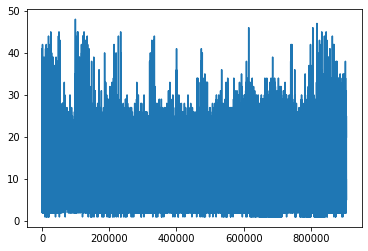

In [ ]:
# distribution of headline lengths. All under 50 tokens.
dfs.headline_len.plot()

In [ ]:
# NAs and duplicates exist in headline
dfs.headline.describe()

count                  905547
unique                 867215
top       Shots - Health News
freq                      866
Name: headline, dtype: object

In [ ]:
dfs.headline_len.describe()

count    905545.000000
mean         11.048977
std           3.316938
min           1.000000
25%           9.000000
50%          11.000000
75%          13.000000
max          48.000000
Name: headline_len, dtype: float64

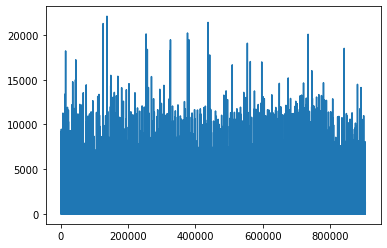

In [ ]:
dfs.body_len.plot()

In [ ]:
# 1 NA and some duplicates exist in body
dfs.body.describe()

count                                                                                                                        905572
unique                                                                                                                       891775
top       News Corp is a network of leading companies in the worlds of diversified media, news, education, and information services
freq                                                                                                                           5418
Name: body, dtype: object

In [ ]:
#lengths of body vary from 15 to 22085 tokens
dfs.body_len.describe()

count    905571.000000
mean        626.440127
std         627.349890
min          15.000000
25%         235.000000
50%         495.000000
75%         850.000000
max       22085.000000
Name: body_len, dtype: float64

### 5. add columns "if_eng_body", "if_eng_headline", "if_eng_headline_nonstrict"

- column "if_eng_body": if "body" is English, then 1 else 0
- column "if_eng_headline": if "headline" is English, then 1 else 0
- column "if_eng_headline_nonstrict" : same as "if_eng_headline" but more accurate because langdetect library is not good at detecting languages in short docs like headline. Further work: more headlines should be classified as English.  

In [ ]:
#return a list of indexes of the rows with non-eng in a text column such as body and headline
def compute_non_eng_indexes(df, column_name, column_lang):
    print(f'dataframe has {len(df)} rows.')
    notnull_indexes = [index for index in range(len(df)) if not df[column_lang][index] != df[column_lang][index]]
    print(f'{len(notnull_indexes)} rows in {column_name} are not null.')
    index_names = [index for index in notnull_indexes if len(re.findall(r'[a-z-]{2,5}', df[column_lang][index]))>1] #return list of indexes containing more than 1 languages
    print(f'{len(index_names)} rows with non-English in {column_name}.')
    
    # make sure no other languages 
    rest_indexes = [item for item in list(df.index) if item not in index_names]
    index_names2 = [] #another list for index to catch non-English rows
    for i in rest_indexes:
      splitted = str(df[column_lang][i])[1:-1].split(":") # return e.g., ['en', '0.999995765868579']
      if splitted[0] =='en':
        if float(splitted[1])<0.99999:
          index_names2.append(i)
      else:
        index_names2.append(i)

    if len(index_names2)==0:
        print(f'double check: no more rows with non-English content in {column_name}')
    else:
        index_names = sorted(index_names + index_names2)
        print(f' found another {len(index_names2)} rows with non-English content in {column_name}.\n In total, {len(index_names)} rows with non-English content in {column_name}.')
    return index_names

In [ ]:
non_eng_indexes_headline = compute_non_eng_indexes(dfs, 'headline', 'headline_lang')

dataframe has 905573 rows.
905547 rows in headline are not null.
84620 rows with non-English in headline.
 found another 9332 rows with non-English content in headline.
 In total, 93952 rows with non-English content in headline.


In [ ]:
non_eng_indexes_body = compute_non_eng_indexes(dfs1, 'body', 'body_lang')


dataframe has 905573 rows.
905572 rows in body are not null.
648 rows with non-English in body.
 found another 4 rows with non-English content in body.
 In total, 652 rows with non-English content in body.


In [ ]:
# add 2 columns: if_eng_headline and if_eng_body
if_eng_1_headline = [0 if i in non_eng_indexes_headline else 1 for i in range(len(dfs))]
dfs['if_eng_headline'] = if_eng_1_headline
if_eng_1_body = [0 if i in non_eng_indexes_body else 1 for i in range(len(dfs))]
dfs['if_eng_body'] = if_eng_1_body

In [ ]:
dfs1['if_eng_body'].value_counts()

1    904921
0       652
Name: if_eng_body, dtype: int64

In [ ]:
dfs1['if_eng_headline'].value_counts()

1    811621
0     93952
Name: if_eng_headline, dtype: int64

In [ ]:
# add 1 column: if_eng_headline_nonstrict

# As long as ENG exists in the detected languages, assign 1 else 0
dfs['if_eng_headline_nonstrict'] = dfs.apply(lambda x: 1 if "en" in str(x['headline_lang']) else 0, axis= 1)
dfs.if_eng_headline_nonstrict.value_counts()

1    891518
0     14055
Name: if_eng_headline_nonstrict, dtype: int64

In [ ]:
dfs.to_csv('full_df_v2_len_lang_added.csv', index = False)
!cp full_df_v2_len_lang_added.csv "gdrive/My Drive/nlp-tm-proj/"

In [ ]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905573 entries, 0 to 905572
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         905573 non-null  object 
 1   date_publish               905572 non-null  object 
 2   outlet                     905573 non-null  object 
 3   headline                   905547 non-null  object 
 4   lead                       840629 non-null  object 
 5   body                       905572 non-null  object 
 6   authors                    732635 non-null  object 
 7   domain                     905571 non-null  object 
 8   url                        905571 non-null  object 
 9   political_leaning          905571 non-null  object 
 10  headline_len               905545 non-null  float64
 11  body_len                   905571 non-null  float64
 12  headline_lang              905547 non-null  object 
 13  body_lang                  90

### 6. add columns: 'preprocessed_body' and 'preprocessed_headline'

- 'preprocessed_body': body with some words and patterns removed
- 'preprocessed_headline': headline with some words and patterns removed

In [ ]:
dfs = pd.read_csv("gdrive/My Drive/nlp-tm-proj/full_df_v2_len_lang_added.csv")
#dfs = vaex.from_csv("gdrive/My Drive/nlp-tm-proj/full_df_v2_len_lang_added.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
remove_words = ['(VIDEO)','BRIEF-','(Reuters)','UPDATE','CORRECTED-BRIEF-','GRAPHIC','NEWSLETTER','CLOSE']
def preprocess_text(text):
    patterns = r'|'.join(remove_words)
    text = re.sub(r"http\S+|@\S+", "", str(text))
    text = re.sub(patterns, "", str(text))
    return text

In [ ]:
# add preprocessed_headline and preprocessed_body

dfs['preprocessed_headline'] = dfs['headline'].apply(preprocess_text)
dfs['preprocessed_body'] = dfs['body'].apply(preprocess_text)

# fix the headlines with length == 1 and with a pattern like aa-bb-cc-dd. It's treated as one token when tokenizing, so we will remove "-". 
dfs['preprocessed_headline'] = dfs.apply(lambda x: x.preprocessed_headline.replace("-"," ") if x.headline_len ==1 else x.preprocessed_headline, axis = 1)


### 7. add 'if_meaningful_headline' and 'if_meaningful_body'

- 'if_meaningful_headline': if headline is meaningless content, assign 0 else 1
- 'if_meaningful_body': if body is meaningless content, assign 0 else 1

In [ ]:
meaningless_headlines = ['Video','Business Highlights','Week ahead','AP NewsAlert','- CNNPolitics.com',
                         'World Watch','Finance Watch','Media reports','Government Source',
                         '5 Years','POLITICO Magazine','NBC News','Quickly']
meaningless_bodies = ["Tap here to turn on desktop notifications to get the news sent straight to you.",
                  "Chat with us in Facebook Messenger. Find out what's happening in the world as it unfolds.",
                  "News Corp is a network of leading companies in the worlds of diversified media, news, education, and information services",
                  ]
dfs['if_meaningful_headline'] = dfs.apply(lambda x: 0 if x['headline'] in meaningless_headlines or x['headline'] !=x['headline'] else 1, axis =1)
dfs['if_meaningful_body'] = dfs.apply(lambda x: 0 if x['body'] in meaningless_bodies else 1, axis =1)

In [ ]:
dfs['if_meaningful_headline'].value_counts()

1    904866
0       707
Name: if_meaningful_headline, dtype: int64

In [ ]:
dfs['if_meaningful_body'].value_counts()

1    899025
0      6548
Name: if_meaningful_body, dtype: int64

In [ ]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905573 entries, 0 to 905572
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         905573 non-null  object 
 1   date_publish               905572 non-null  object 
 2   outlet                     905573 non-null  object 
 3   headline                   905547 non-null  object 
 4   lead                       840629 non-null  object 
 5   body                       905572 non-null  object 
 6   authors                    732635 non-null  object 
 7   domain                     905571 non-null  object 
 8   url                        905571 non-null  object 
 9   political_leaning          905571 non-null  object 
 10  headline_len               905545 non-null  float64
 11  body_len                   905571 non-null  float64
 12  headline_lang              905547 non-null  object 
 13  body_lang                  90

### 8. save the final dataframe to files

The dataframe is large with more than 900k rows. We split it to parts and save them to multiple csv files, to avoid bugs when saving or reading a large file using Google Drive. 

In [ ]:
dfs.iloc[:200000,:].to_csv('df_v3_1_200000.csv', index = False)
!cp df_v3_1_200000.csv "gdrive/My Drive/PolUSA-data/"

In [ ]:
dfs.iloc[200000:400000,:].to_csv('df_v3_200000_400000.csv', index = False)
!cp df_v3_200000_400000.csv "gdrive/My Drive/PolUSA-data/"

In [ ]:
dfs.iloc[400000:600000,:].to_csv('df_v3_400000_600000.csv', index = False)
!cp df_v3_400000_600000.csv "gdrive/My Drive/PolUSA-data/"

In [ ]:
dfs.iloc[600000:800000,:].to_csv('df_v3_600000_800000.csv', index = False)
!cp df_v3_600000_800000.csv "gdrive/My Drive/PolUSA-data/"

In [ ]:
dfs.iloc[800000:850000,:].to_csv('df_v3_800000_850000.csv', index = False)
!cp df_v3_800000_850000.csv "gdrive/My Drive/PolUSA-data/"

In [ ]:
dfs.iloc[850000:905573,:].to_csv('df_v3_850000_905573.csv', index = False)
!cp df_v3_850000_905573.csv "gdrive/My Drive/PolUSA-data/"